In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

%matplotlib inline

**Churn** = the event when customers stops buying the product or unsubscribe from the service

Churn can be:
- contractual (e.g. TV subscription) /non-contractual (e.g. online shopping/ more difficult to define & model)
- voluntary/involuntary (e.g. credit-card expiration)

In this project, I predict churn based on data from telecom company. This means that churn is clearly defined when a customer cancels the subscription.

## Step 1: Load and Explore Data

In [2]:
telco = pd.read_csv("telco_churn.csv")

In [3]:
telco.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
telco.shape

(7043, 21)

In [5]:
# checking duplicates
telco.duplicated().sum()

0

In [6]:
# checking data types
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
telco.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Note: seems like we have lots of categorical columns. We need to separate them from numerical (like MonthlyCharges, TotalCharges). Plus because we have lots of columns recorded as 'object' (categorical) we cannot really check how many missing values there are. Running telco.isna().sum() will produce incorrect results.

In [53]:
# explore the target variable
print(set(telco['Churn']))
telco.groupby(telco['Churn']).size()/telco.shape[0]

{'No', 'Yes'}


Churn
No     0.73463
Yes    0.26537
dtype: float64

Note: 73% of customers did not churn, while 27% churned. There is some class imbalance, but not very bad one. Typically, we might start to worry when the minority class is less than 5-10%. We have to deal with class imbalances in this case with oversampling/undersampling techniques.

## Step 2: Data Pre-Processing

In [8]:
# store identifier and target variable separately
custid = ['customerID']
target = ['Churn']
custid[0], target[0]

('customerID', 'Churn')

In [9]:
# separating categorical variables from numerical
categorical = telco.nunique()[telco.nunique() < 10].keys().tolist()
categorical

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [10]:
numerical = telco.nunique()[telco.nunique() > 10].keys().tolist()
numerical.remove(custid[0])
numerical

['tenure', 'MonthlyCharges', 'TotalCharges']

In [11]:
# alternative method
# numerical = [col for col in telco.columns if col not in custid+categorical+target]

### One-Hot Encoding of Categorical Features

In [235]:
# drop first encoded column because it can be inferred from other columns and thus is redundant
telco_ohe = pd.get_dummies(data=telco, columns=categorical, drop_first=True)

In [236]:
telco_ohe.head()

customerID  tenure  MonthlyCharges TotalCharges  gender_Male  \
0  7590-VHVEG       1           29.85        29.85            0   
1  5575-GNVDE      34           56.95       1889.5            1   
2  3668-QPYBK       2           53.85       108.15            1   
3  7795-CFOCW      45           42.30      1840.75            1   
4  9237-HQITU       2           70.70       151.65            0   

   SeniorCitizen_1  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0                0            1               0                 0   
1                0            0               0                 1   
2                0            0               0                 1   
3                0            0               0                 0   
4                0            0               0                 1   

   MultipleLines_No phone service  ...  StreamingTV_Yes  \
0                               1  ...                0   
1                               0  ...                0   
2                               0  ...                0   
3                               1  ...                0   
4                               0  ...                0   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                    0                    0   
1                                    0                    0   
2                                    0                    0   
3                                    0                    0   
4                                    0                    0   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                  0                  0                     1   
1                  1                  0                     0   
2                  0                  0                     1   
3                  1                  0                     0   
4                  0                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  Churn_Yes  
0                           0          0  
1                           1          0  
2                           1          1  
3                           0          0  
4                           0          1  

[5 rows x 32 columns]

### Scaling of Numerical Features

In [237]:
telco_ohe[numerical].dtypes

tenure              int64
MonthlyCharges    float64
TotalCharges       object
dtype: object

Note: we need to fix TotalCharges feature. It is encoded as 'object', which is not numerical. 

In [238]:
# replacing missing values for TotalCharges with 0s for 11 customers 
# after checking that no customer had values with 0 total charges (could mean that these are new customers?)
telco_ohe['TotalCharges'] = telco_ohe.TotalCharges.replace({" ": 0})
telco_ohe['TotalCharges'].isna().sum()

0

In [82]:
telco_ohe['TotalCharges'] = pd.to_numeric(telco_ohe['TotalCharges'])

In [83]:
scaler = StandardScaler() 
scaled_numerical = scaler.fit_transform(telco_ohe[numerical])
scaled_numerical

array([[-1.27744458, -1.16032292, -0.99261052],
       [ 0.06632742, -0.25962894, -0.17216471],
       [-1.23672422, -0.36266036, -0.9580659 ],
       ...,
       [-0.87024095, -1.1686319 , -0.85293201],
       [-1.15528349,  0.32033821, -0.87051315],
       [ 1.36937906,  1.35896134,  2.01389665]])

In [84]:
# we need to add scaled numerical features back to our telco dataset

scaled_df = pd.DataFrame(data=scaled_numerical, columns=numerical)
# drop non-scaled numerical features from telco_ohe
telco_ohe.drop(numerical, axis='columns', inplace=True)

In [85]:
# merge the scaled_numerical with telco_ohe
telco_ohe_scaled = telco_ohe.merge(scaled_df, how='left', left_index=True, right_index=True)

telco_ohe_scaled.head()

customerID  gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
0  7590-VHVEG            0                0            1               0   
1  5575-GNVDE            1                0            0               0   
2  3668-QPYBK            1                0            0               0   
3  7795-CFOCW            1                0            0               0   
4  9237-HQITU            0                0            0               0   

   PhoneService_Yes  MultipleLines_No phone service  MultipleLines_Yes  \
0                 0                               1                  0   
1                 1                               0                  0   
2                 1                               0                  0   
3                 0                               1                  0   
4                 1                               0                  0   

   InternetService_Fiber optic  InternetService_No  ...  Contract_One year  \
0                            0                   0  ...                  0   
1                            0                   0  ...                  1   
2                            0                   0  ...                  0   
3                            0                   0  ...                  1   
4                            1                   0  ...                  0   

   Contract_Two year  PaperlessBilling_Yes  \
0                  0                     1   
1                  0                     0   
2                  0                     1   
3                  0                     0   
4                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  Churn_Yes    tenure  MonthlyCharges  \
0                           0          0 -1.277445       -1.160323   
1                           1          0  0.066327       -0.259629   
2                           1          1 -1.236724       -0.362660   
3                           0          0  0.514251       -0.746535   
4                           0          1 -1.236724        0.197365   

   TotalCharges  
0     -0.992611  
1     -0.172165  
2     -0.958066  
3     -0.193672  
4     -0.938874  

[5 rows x 32 columns]

## Step 3: Supervised Modeling

## Splitting into Test and Training

In [86]:
y = telco_ohe_scaled['Churn_Yes']
X = telco_ohe_scaled.drop(['customerID', 'Churn_Yes'], axis='columns')

In [87]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn_Yes, dtype: uint8

In [93]:
X.head()

gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
0            0                0            1               0   
1            1                0            0               0   
2            1                0            0               0   
3            1                0            0               0   
4            0                0            0               0   

   PhoneService_Yes  MultipleLines_No phone service  MultipleLines_Yes  \
0                 0                               1                  0   
1                 1                               0                  0   
2                 1                               0                  0   
3                 0                               1                  0   
4                 1                               0                  0   

   InternetService_Fiber optic  InternetService_No  \
0                            0                   0   
1                            0                   0   
2                            0                   0   
3                            0                   0   
4                            1                   0   

   OnlineSecurity_No internet service  ...  StreamingMovies_Yes  \
0                                   0  ...                    0   
1                                   0  ...                    0   
2                                   0  ...                    0   
3                                   0  ...                    0   
4                                   0  ...                    0   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                  0                  0                     1   
1                  1                  0                     0   
2                  0                  0                     1   
3                  1                  0                     0   
4                  0                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check    tenure  MonthlyCharges  TotalCharges  
0                           0 -1.277445       -1.160323     -0.992611  
1                           1  0.066327       -0.259629     -0.172165  
2                           1 -1.236724       -0.362660     -0.958066  
3                           0  0.514251       -0.746535     -0.193672  
4                           0 -1.236724        0.197365     -0.938874  

[5 rows x 30 columns]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1023)

### Modeling with Logistic Regression

In [97]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
y_pred = logistic.predict(X_test)

In [231]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(logistic.coef_))], axis='columns')
coefficients.columns = ['Feature', 'Coefficient']
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient'] != 0]
coefficients.sort_values(by='Exp_Coefficient')

Feature  Coefficient  Exp_Coefficient
22                      Contract_Two year    -1.133250         0.321985
27                                 tenure    -1.027866         0.357770
4                        PhoneService_Yes    -1.005511         0.365858
21                      Contract_One year    -0.601414         0.548036
10                     OnlineSecurity_Yes    -0.429393         0.650904
16                        TechSupport_Yes    -0.419641         0.657283
12                       OnlineBackup_Yes    -0.262760         0.768926
3                          Dependents_Yes    -0.216557         0.805286
14                   DeviceProtection_Yes    -0.092652         0.911511
24  PaymentMethod_Credit card (automatic)    -0.092564         0.911591
26             PaymentMethod_Mailed check    -0.062623         0.939298
0                             gender_Male    -0.008988         0.991052
6                       MultipleLines_Yes     0.048338         1.049525
7             InternetService_Fiber optic     0.091968         1.096330
1                         SeniorCitizen_1     0.182509         1.200225
29                           TotalCharges     0.222779         1.249544
23                   PaperlessBilling_Yes     0.247094         1.280300
25         PaymentMethod_Electronic check     0.277666         1.320046
28                         MonthlyCharges     0.810383         2.248770

Note: interpretation for odds - values less than 1 decrease the odds, values > 1 increase the odds. So having Contract_Two year (increase by 1 in its value) decreases the odds of churn by 1-0.32=0.78. Increase in 1 year of tenure decreases the churn odds by about 64%.

### Model Performance

In [131]:
test_accuracy = accuracy_score(y_test, y_pred).round(4)
test_recall = recall_score(y_test, y_pred).round(4)
test_precision = precision_score(y_test, y_pred).round(4)
test_f1score = f1_score(y_test, y_pred).round(4)

print(f"Test Accuracy: {test_accuracy}") 
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test f1_score: {test_f1score}")

Test Accuracy: 0.8119
Test Recall: 0.5385
Test Precision: 0.6689
Test f1_score: 0.5967


Note: recall and precision scores are lower than accuracy, which means that the model predicts the minority class (Churn) worse than the majority class (Non-Churn).

## Step 4: Model Tuning

In [129]:
clf = LogisticRegression(random_state=12, solver='liblinear')

parameters = {"penalty": ['l1', 'l2'],
             "C": [1, .5, .25, .1, .05, .025]}

scorer = make_scorer(f1_score)

# Perform grid search on the classifier using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))

/Users/kbosko/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8119
F-score on testing data: 0.5979

Optimized Model
------
Final accuracy score on the testing data: 0.8126
Final F-score on the testing data: 0.5963


In [130]:
best_clf

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [142]:
# Tuning C-level in L1 regularization

C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 6))
l1_metrics[:, 0] = C

# Run a for loop over the range of C list length
for index in range(0, len(C)):
    # Initialize and fit Logistic Regression with the C candidate
    logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
    logreg.fit(X_train, y_train)
    # Predict churn on the testing data
    y_test_pred = logreg.predict(X_test)
    # Create non-zero count and recall score columns
    l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index,2] = accuracy_score(y_test, y_test_pred).round(4)
    l1_metrics[index,3] = precision_score(y_test, y_test_pred).round(4)
    l1_metrics[index,4] = recall_score(y_test, y_test_pred).round(4)  
    l1_metrics[index,5] = f1_score(y_test, y_test_pred).round(4)


# Name the columns and print the array as pandas DataFrame
col_names = ['C','Non-Zero Coeffs','Accuracy', 'Precision', 'Recall', 'F1_score']
print(pd.DataFrame(l1_metrics, columns=col_names))

        C  Non-Zero Coeffs  Accuracy  Precision  Recall  F1_score
0  1.0000             29.0    0.8112     0.6667  0.5385    0.5957
1  0.5000             22.0    0.8126     0.6724  0.5357    0.5963
2  0.2500             20.0    0.8133     0.6760  0.5330    0.5960
3  0.1000             19.0    0.8141     0.6821  0.5247    0.5932
4  0.0500             14.0    0.8133     0.6836  0.5165    0.5884
5  0.0250             13.0    0.8055     0.6786  0.4698    0.5552
6  0.0100              8.0    0.7999     0.6990  0.3956    0.5053
7  0.0050              3.0    0.7949     0.7301  0.3269    0.4516
8  0.0025              2.0    0.7473     0.9000  0.0247    0.0481


Note: seems like with C=0.1 we have high accuracy level with less model complexity (19 features) and good precision, recall and f1_scores.

### Tuning RandomForest model

In [157]:
# Tuning max_depth parameter for DecisionTree()
depth_list = range(2, 15)
l1_metrics = np.zeros((len(depth_list), 5))
l1_metrics[:, 0] = max_depth

for index in range(0, len(depth_list)):
    clf = RandomForestClassifier(random_state=123, n_estimators=100, max_depth=depth_list[index])
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    l1_metrics[index,1] = accuracy_score(y_test, y_test_pred).round(4)
    l1_metrics[index,2] = precision_score(y_test, y_test_pred).round(4)
    l1_metrics[index,3] = recall_score(y_test, y_test_pred).round(4)  
    l1_metrics[index,4] = f1_score(y_test, y_test_pred).round(4)

# Name the columns and print the array as pandas DataFrame
col_names = ['Max_depth','Accuracy', 'Precision', 'Recall', 'F1_score']
max_depth_df = pd.DataFrame(l1_metrics, columns=col_names)
max_depth_df

Max_depth  Accuracy  Precision  Recall  F1_score
0         2.0    0.7587     0.7727  0.0934    0.1667
1         3.0    0.7771     0.7358  0.2143    0.3319
2         4.0    0.7984     0.7198  0.3599    0.4799
3         5.0    0.7991     0.6995  0.3901    0.5009
4         6.0    0.7977     0.6854  0.4011    0.5061
5         7.0    0.8034     0.6916  0.4313    0.5313
6         8.0    0.8013     0.6842  0.4286    0.5270
7         9.0    0.8013     0.6694  0.4560    0.5425
8        10.0    0.8006     0.6627  0.4643    0.5460
9        11.0    0.8027     0.6720  0.4615    0.5472
10       12.0    0.7984     0.6460  0.4863    0.5549
11       13.0    0.8091     0.6792  0.4945    0.5723
12       14.0    0.7970     0.6477  0.4698    0.5446

Note: max_depth of 13 rules produces the best performance - the highest accuracy, the highest recall and f1_score as well as relatively high precision.

In [201]:
rf_model = RandomForestClassifier(random_state=123, n_estimators=100, max_depth=13)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)

### Visualize Tree Decisions 

In [203]:
# extract single tree
estimator = rf_model.estimators_[99]
estimator

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1080368952, splitter='best')

In [204]:
exported = export_graphviz(decision_tree=estimator, 
                           out_file=None, # alternative out_file='tree.dot' to save as png
                           max_depth = 4, #with large max_depth, tree is too big to viz. limit it here for better viz
                           feature_names=X.columns, 
                           precision=1, 
                           class_names=['Not Churn', 'Churn'],
                           proportion=True,
                           filled=True) #paint nodes to indicate majority class for classification

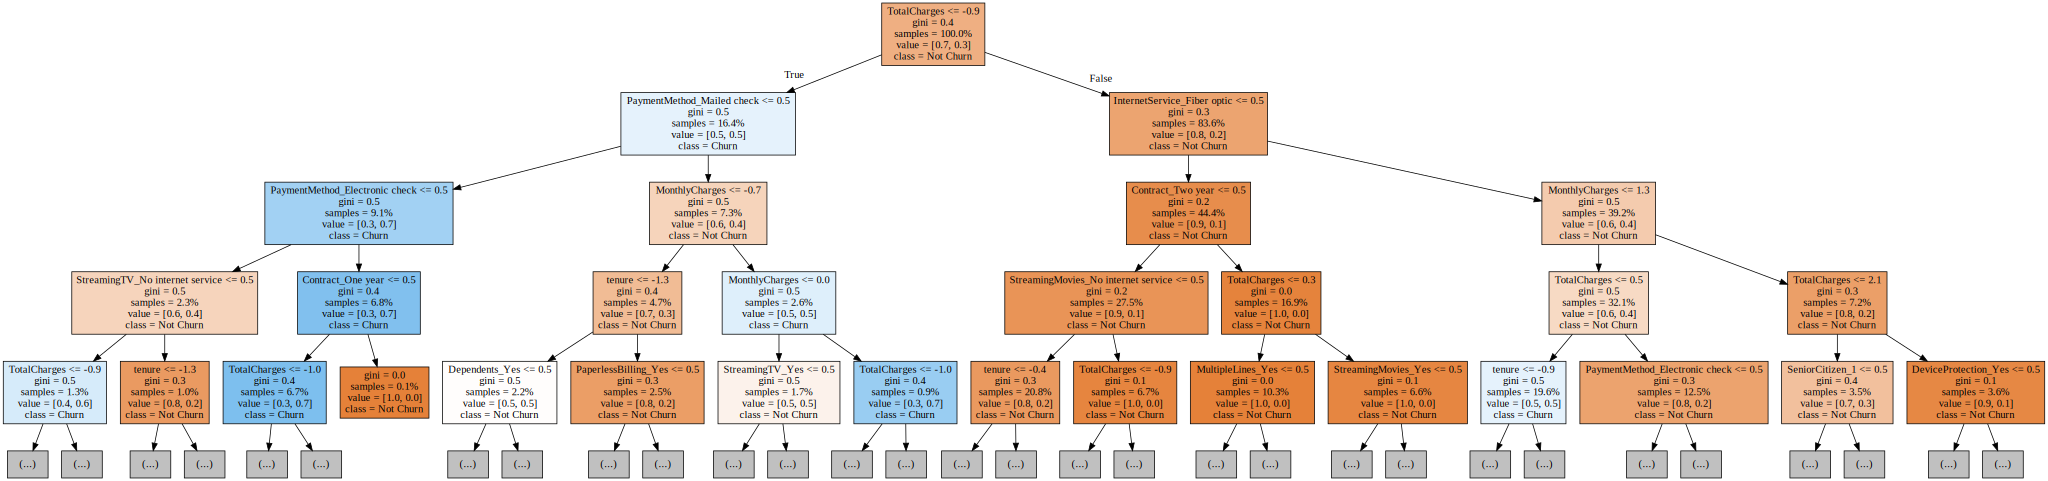

In [196]:
graph = graphviz.Source(exported)
display(graph)

### Acknowledgement:

This [post on Medium by Will Koehrsen](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c) about how to visualize a Decision Tree from Random Forest was particularly useful.

In [205]:
exported = export_graphviz(decision_tree=estimator, 
                           out_file='tree.dot', # alternative out_file='tree.dot' to save as png
                           max_depth = 4, #with large max_depth, tree is too big to viz. limit it here for better viz
                           feature_names=X.columns, 
                           precision=1, 
                           class_names=['Not Churn', 'Churn'], 
                           proportion=True,
                           filled=True) #paint nodes to indicate majority class for classification

In [206]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')